# Imports etc.

In [1]:
import json
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)

In [2]:
data_dir = 'C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1'
plot_dir = data_dir + 'figures'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Get data

In [3]:
def raw_data_row2pd(data_row):
    
    return pd.DataFrame(json.loads(data_row['trialdata']))

# # Use
# pd.concat([raw_data_row2pd(task_data_raw[i[0]]) for i in trial_data_rows])

In [4]:
def raw_data2rules_data(rule_row):
    
    # Get rules data
    rule_cols = ['middleRules', 'lowTransferRules', 'highTransferRules', 'highRules', 'taskVer', 'phaseNum']
    rules_dat = pd.DataFrame({rule_col: rule_row['trialdata'][rule_col] for rule_col in rule_cols})
    
    # Clean it up
    rules_dat = rules_dat.reset_index().rename(columns={'index': 'goal_id'})
    rules_dat['taskVer'] = rules_dat['taskVer'].replace({'A': 'high', 'B': 'low'})
    rules_dat = rules_dat.rename(columns={'middleRules': 'lowRules', 'taskVer': 'phase'})
    
    return rules_dat

# # Use
# pd.concat([raw_data2rules_data(rule_row) for rule_row in rule_rows])
# # raw_data2rules_data(rule_rows[0])

In [5]:
# Read in and process data
file_names = os.listdir(data_dir)
all_data = pd.DataFrame()
all_rules = pd.DataFrame()

for sid, file_name in enumerate(file_names):
    
    # Read in raw data
    with open(os.path.join(data_dir, file_name)) as f:
        raw_data = json.load(f)

    # Get actual task data
    subj_data_raw = raw_data['data']

    trial_data_len = [len(subj_data_raw[i]['trialdata']) for i in range(len(subj_data_raw))]
    trial_data_rows = np.argwhere(np.array(trial_data_len) > 10000).flatten()  # rows with less than 10000 entries contain other stuff (e.g., rules)

    subj_data = pd.concat([raw_data_row2pd(subj_data_raw[i]) for i in trial_data_rows])
    
    # Add basic info
    subj_data['sid'] = sid
    subj_data['workerId'] = raw_data['workerId']
    subj_data['counterbalance'] = raw_data['counterbalance']
    subj_data['start_dateTime'] = raw_data['data'][0]['dateTime']
    subj_data['end_dateTime'] = raw_data['data'][-1]['dateTime']

    # Combine all subjects
    all_data = pd.concat([all_data, subj_data])
    
    # Get rule data
    rule_row_idx = np.argwhere(np.array(trial_data_len) == 21).flatten()  # trials with length 21 contain the rules
    rule_rows = [raw_data['data'][i] for i in rule_row_idx]
    
    subj_rules = pd.concat([raw_data2rules_data(rule_row) for rule_row in rule_rows])
    subj_rules['sid'] = sid
    
    all_rules = pd.concat([all_rules, subj_rules])

all_rules

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,goal_id,lowRules,lowTransferRules,highTransferRules,highRules,phase,phaseNum,sid
0,1,"[3, 0]","[3, 1]","[3, 0]","[3, 1]",low,0,0
1,0,"[2, 3]","[2, 3]","[1, 2]","[1, 2]",low,0,0
2,3,"[1, 2]","[0, 2]","[1, 3]","[0, 3]",low,0,0
3,2,"[0, 1]","[0, 1]","[2, 0]","[2, 0]",low,0,0
0,1,"[3, 0]","[3, 1]","[1, 2]","[3, 2]",high,0,1
1,0,"[0, 1]","[0, 1]","[1, 0]","[1, 0]",high,0,1
2,3,"[2, 3]","[2, 3]","[2, 3]","[2, 1]",high,0,1
3,2,"[1, 2]","[0, 2]","[0, 3]","[0, 3]",high,0,1
0,1,"[0, 1]","[0, 1]","[0, 1]","[0, 1]",low,0,2
1,0,"[3, 0]","[3, 1]","[0, 2]","[3, 2]",low,0,2


## Clean all_data

In [6]:
interesting_cols = [
    'rt', 'acc', 'trial_type', 'phase', 'block', 'trial', 'trial_', 'subtrial', 'points', #'key_press',
    'action_id', 'middle_item_name', 'goal_star_name', 'goal_star', 'correct', 'unlocked_star', #'middle_item',
    'unlocked_star_name', 'timeout', 'duration', #'action_name',
]

In [7]:
def msec2min(msec):
    
    sec = msec / 1000
    minutes = sec / 60
    return minutes

# Example use
s19 = 1806710 - 145800
s67 = 1913718 - 56652
msec2min(s19), msec2min(s67)

(27.681833333333334, 30.9511)

In [8]:
all_data = all_data.loc[all_data.trial_type.isin(['learning', 'transfer'])]  # remove instructions
all_data = all_data.loc[all_data.subtrial.isin(range(4))]  # remove 5th (feedback) trial
all_data['phase'] = all_data['phase'].replace({'A': 'high', 'B': 'low'})
all_data['trial_'] = all_data['block'] * 25 + all_data['trial']  # get continuous trials over blocks
all_data['duration'] = msec2min(all_data['end_dateTime'] - all_data['start_dateTime'])  # task duration
acc_mask = all_data['subtrial'] == 3
all_data.loc[acc_mask, 'acc'] = (all_data.loc[acc_mask, 'goal_star'] == all_data.loc[acc_mask, 'unlocked_star']).astype(int)  # acc of each trial (`correct` is only for successful star trials)
all_data = all_data.reset_index(drop=True)
all_data[interesting_cols]

,rt,acc,trial_type,phase,block,trial,trial_,subtrial,points,action_id,middle_item_name,goal_star_name,goal_star,correct,unlocked_star,unlocked_star_name,timeout,duration
0,2263.780,NaN,learning,low,0,0,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.60445
1,28.155,NaN,learning,low,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.60445
2,242.760,NaN,learning,low,0,0,0,2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.60445
3,236.630,0.0,learning,low,0,0,0,3,0,1,NaN,0.0,3.0,NaN,-1.0,-1.0,NaN,16.60445
4,970.630,NaN,learning,low,0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.60445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,168.945,1.0,transfer,high,6,23,173,3,289,3,0.0,1.0,1.0,True,1.0,1.0,NaN,31.97000
19700,302.075,NaN,transfer,high,6,24,174,0,289,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.97000
19701,331.825,NaN,transfer,high,6,24,174,1,289,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,31.97000
19702,253.500,NaN,transfer,high,6,24,174,2,289,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.97000


In [9]:
all_data.columns

Index(['action_id', 'action_name', 'block', 'correct', 'goal_star',
       'goal_star_name', 'internal_node_id', 'key_press', 'middle_item',
       'middle_item_name', 'phase', 'points', 'rt', 'stimulus', 'subtrial',
       'time_elapsed', 'timeout', 'trial', 'trial_index', 'trial_type',
       'unlocked_star', 'unlocked_star_name', 'sid', 'workerId',
       'counterbalance', 'start_dateTime', 'end_dateTime', 'trial_',
       'duration', 'acc'],
      dtype='object')

## Clean rule_data

In [42]:
# Select rule columns
rule_cols_sub = ['sid', 'goal_id', 'lowRules', 'highRules', 'lowTransferRules', 'highTransferRules', 'phase']
rule_data = all_rules[rule_cols_sub]

# Replace hypothetical, never-used transfer rules with the actual experimental rule during that phase
rule_data.loc[rule_data.phase == 'low', 'highTransferRules'] = rule_data.loc[rule_data.phase == 'low', 'highRules']
rule_data.loc[rule_data.phase == 'high', 'lowTransferRules'] = rule_data.loc[rule_data.phase == 'high', 'lowRules']
rule_data

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,sid,goal_id,lowRules,highRules,lowTransferRules,highTransferRules,phase
0,0,1,"[3, 0]","[3, 1]","[3, 1]","[3, 1]",low
1,0,0,"[2, 3]","[1, 2]","[2, 3]","[1, 2]",low
2,0,3,"[1, 2]","[0, 3]","[0, 2]","[0, 3]",low
3,0,2,"[0, 1]","[2, 0]","[0, 1]","[2, 0]",low
0,1,1,"[3, 0]","[3, 2]","[3, 0]","[1, 2]",high
1,1,0,"[0, 1]","[1, 0]","[0, 1]","[1, 0]",high
2,1,3,"[2, 3]","[2, 1]","[2, 3]","[2, 3]",high
3,1,2,"[1, 2]","[0, 3]","[1, 2]","[0, 3]",high
0,2,1,"[0, 1]","[0, 1]","[0, 1]","[0, 1]",low
1,2,0,"[3, 0]","[3, 2]","[3, 1]","[3, 2]",low


## Add hypothetical middle-level items and stars to all_data

In [129]:
def actions2items(trial_rules, actions, low_rule_name):
    
    items = 4 * [np.nan]

    for goal_id in trial_rules.goal_id:
        goal_rule = get_goal_rule(trial_rules, goal_id, low_rule_name)
        
        for i, action_tuple in enumerate([np.array(actions[:2]), np.array(actions[2:])]):
            if np.all(action_tuple == goal_rule):
                items[2 * i + 1] = int(goal_id)

    return items
        
# Use
actions = [3, 0, 2, 3]
actions = [3, 1, 2, 3]
actions2items(trial_rules, actions, 'lowRules')

[nan, nan, nan, 0]

In [130]:
def items2stars(trial_rules, items, high_rule_name):

    for goal_id in trial_rules.goal_id:

        goal_rule = get_goal_rule(trial_rules, goal_id, high_rule_name)
        comp_items = np.array([items[1], items[3]])

        # Valid sequence of two items
        if np.all(goal_rule == comp_items):
            return 3 * [np.nan,] + [int(goal_id)]

    # No valid sequence of two items
    return 4 * [np.nan,]
        
# Use
items = [np.nan, 1, np.nan, 2]
items2stars(trial_rules, items, high_rule_name)

[nan, nan, nan, 0]

In [131]:
# Add a columns for each rule
for sid in set(all_data.sid):
    print(' sid: {}'.format(sid))
    
    for trial_type in set(all_data.trial_type):
        print('  trial_type: {}'.format(trial_type))
        
        for phase in set(all_data.phase):
            print('   phase: {}'.format(phase))

            # Get rules for this sid and this phase
            trial_rules = rule_data.loc[
                (rule_data.sid == sid) & (rule_data.phase == phase)
            ]
            
            if trial_rules.shape[0] > 0:

                for block in set(all_data.block):

                    for trial in set(all_data.trial):

                        all_data_mask = (all_data.sid == sid) & (all_data.phase == phase) & (
                            all_data.trial_type == trial_type) & (all_data.block == block) & (all_data.trial == trial)

                        # Get actions and items for this sid, this phase, this trial_type, this block, and this trial
                        trial_dat = all_data.loc[all_data_mask]
                        actions = trial_dat.action_id
                        items = list(trial_dat.middle_item_name)

                        if trial_dat.shape[0] == 4:  # Make sure we have 4 valid trials

                            for rule_name in [c for c in rule_data.columns if 'Rules' in c]:
                                if 'low' in rule_name:

                                    pred_middle_items = actions2items(trial_rules, actions, rule_name)
                                    all_data.loc[all_data_mask, 'middle_item_' + rule_name] = pred_middle_items

                                if 'high' in rule_name:

                                    pred_star = items2stars(trial_rules, items, rule_name)
                                    all_data.loc[all_data_mask, 'unlocked_star_' + rule_name] = pred_star

 sid: 0
  trial_type: transfer
   phase: high
(0, 7)
   phase: low
(4, 7)
  trial_type: learning
   phase: high
(0, 7)
   phase: low
(4, 7)
 sid: 1
  trial_type: transfer
   phase: high
(4, 7)
   phase: low
(0, 7)
  trial_type: learning
   phase: high
(4, 7)
   phase: low
(0, 7)
 sid: 2
  trial_type: transfer
   phase: high
(4, 7)
   phase: low
(4, 7)
  trial_type: learning
   phase: high
(4, 7)
   phase: low
(4, 7)
 sid: 3
  trial_type: transfer
   phase: high
(0, 7)
   phase: low
(4, 7)
  trial_type: learning
   phase: high
(0, 7)
   phase: low
(4, 7)
 sid: 4
  trial_type: transfer
   phase: high
(4, 7)
   phase: low
(0, 7)
  trial_type: learning
   phase: high
(4, 7)
   phase: low
(0, 7)
 sid: 5
  trial_type: transfer
   phase: high
(0, 7)
   phase: low
(8, 7)
  trial_type: learning
   phase: high
(0, 7)
   phase: low
(8, 7)
 sid: 6
  trial_type: transfer
   phase: high
(4, 7)
   phase: low
(4, 7)
  trial_type: learning
   phase: high
(4, 7)
   phase: low
(4, 7)
 sid: 7
  trial_type

In [146]:
all_data['cor_middle_item_lowRules'] = np.invert(np.isnan(all_data['middle_item_lowRules'])).astype(int)
all_data['cor_unlocked_star_highRules'] = np.invert(np.isnan(all_data['unlocked_star_highRules'])).astype(int)
all_data['cor_middle_item_lowTransferRules'] = np.invert(np.isnan(all_data['middle_item_lowTransferRules'])).astype(int)
all_data['cor_unlocked_star_highTransferRules'] = np.invert(np.isnan(all_data['unlocked_star_highTransferRules'])).astype(int)

In [144]:
interesting_cols += [
    'middle_item_lowTransferRules', 'middle_item_lowRules', 'cor_middle_item_lowRules'
    'unlocked_star_highTransferRules', 'unlocked_star_highRules', 'cor_unlocked_star_highRules'
]

# Results

## Data overview

In [133]:
id_cols = ['sid', 'trial_type', 'phase']
all_data[interesting_cols + id_cols].groupby(id_cols[0]).mean()

,rt,acc,block,trial,trial_,subtrial,points,action_id,middle_item_name,goal_star_name,goal_star,unlocked_star,unlocked_star_name,duration,middle_item_lowTransferRules,middle_item_lowRules,unlocked_star_highTransferRules,unlocked_star_highRules
sid,,,,,,,,,,,,,,,,,,
0,236.062123,0.000000,5.761194,11.966418,155.996269,1.484142,0.000000,1.496269,0.227273,1.378788,1.416667,-0.996212,-0.988636,16.604450,1.594059,0.227273,2.000000,2.000000
1,376.155199,0.000000,5.023787,12.096099,137.690771,1.474786,0.000000,1.455756,1.181818,1.655039,1.341085,-0.996124,-0.988372,14.029700,1.181818,1.181818,1.500000,2.000000
2,192.550253,0.149495,4.718459,12.057668,130.019139,1.496097,88.718711,1.492571,1.267001,1.508081,1.491919,-0.119192,1.990909,27.136767,1.275057,1.263476,2.504751,2.483607
3,403.321016,0.010345,5.588737,11.959044,151.677474,1.487201,2.290956,1.575939,1.505263,1.493103,1.524138,-0.927586,-0.958621,13.287150,1.009901,1.505263,0.333333,0.333333
4,140.097583,0.000000,5.791923,12.125549,156.923617,1.472344,0.000000,1.482880,0.957219,1.541219,1.469534,-0.903226,-0.928315,9.294817,0.957219,0.957219,1.000000,1.000000
5,353.886932,0.000000,5.610497,12.006446,152.268877,1.490792,0.000000,1.472376,1.119048,1.475836,1.386617,-0.962825,-0.962825,18.512017,1.586207,1.880952,3.000000,3.000000
6,435.994964,0.487412,4.714896,12.005024,129.877418,1.497362,191.630746,1.468726,1.505030,1.302115,1.503525,0.245720,0.492447,44.113450,1.453973,1.353725,1.701087,1.794872
7,406.903453,0.003571,5.561847,12.061847,151.108014,1.472997,0.385017,1.252613,0.799020,1.525000,1.475000,-0.917857,-0.707143,13.934167,0.796020,0.796020,2.809524,2.904762
8,275.313791,0.040134,5.513784,11.992481,149.837093,1.498747,5.451128,1.540518,1.592233,1.505017,1.505017,-0.732441,-0.719064,11.484367,1.136508,1.592233,0.076923,0.076923


In [134]:
all_data[interesting_cols].describe()

,rt,acc,block,trial,trial_,subtrial,points,action_id,middle_item_name,goal_star_name,goal_star,unlocked_star,unlocked_star_name,duration,middle_item_lowTransferRules,middle_item_lowRules,unlocked_star_highTransferRules,unlocked_star_highRules
count,19587.000000,4892.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,19704.000000,5598.000000,4892.000000,4892.000000,4892.000000,4892.000000,19704.000000,5716.000000,5337.000000,1823.000000,1722.000000
mean,306.476086,0.191128,5.036845,12.025325,137.946458,1.491575,73.872107,1.483963,1.317256,1.497956,1.475470,-0.377760,0.133074,26.197468,1.313681,1.293611,1.897422,1.950639
std,320.723604,0.393230,3.312339,7.214446,83.105614,1.119845,102.855748,1.124466,1.083486,1.098034,1.005613,0.968519,1.574457,11.666638,1.104874,1.070151,1.084219,1.104322
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,9.294817,0.000000,0.000000,0.000000,0.000000
25%,129.000000,0.000000,2.000000,6.000000,68.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,-1.000000,14.029700,0.000000,0.000000,1.000000,1.000000
50%,214.365000,0.000000,5.000000,12.000000,134.000000,1.000000,26.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,27.136767,1.000000,1.000000,2.000000,2.000000
75%,342.175000,0.000000,8.000000,18.000000,202.000000,2.000000,119.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,31.970000,2.000000,2.000000,3.000000,3.000000
max,2496.535000,1.000000,11.000000,24.000000,299.000000,3.000000,487.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,44.113450,3.000000,3.000000,3.000000,3.000000


In [135]:
all_data.loc[:30, interesting_cols]

,rt,acc,trial_type,phase,block,trial,trial_,subtrial,points,action_id,...,goal_star,correct,unlocked_star,unlocked_star_name,timeout,duration,middle_item_lowTransferRules,middle_item_lowRules,unlocked_star_highTransferRules,unlocked_star_highRules
0,2263.780,NaN,learning,low,0,0,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,16.60445,NaN,NaN,NaN,NaN
1,28.155,NaN,learning,low,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,16.60445,NaN,NaN,NaN,NaN
2,242.760,NaN,learning,low,0,0,0,2,0,2,...,NaN,NaN,NaN,NaN,NaN,16.60445,NaN,NaN,NaN,NaN
3,236.630,0.0,learning,low,0,0,0,3,0,1,...,3.0,NaN,-1.0,-1.0,NaN,16.60445,NaN,NaN,NaN,NaN
4,970.630,NaN,learning,low,0,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,16.60445,NaN,NaN,NaN,NaN
5,109.190,NaN,learning,low,0,1,1,1,0,2,...,NaN,NaN,NaN,NaN,NaN,16.60445,3.0,NaN,NaN,NaN
6,260.995,NaN,learning,low,0,1,1,2,0,1,...,NaN,NaN,NaN,NaN,NaN,16.60445,NaN,NaN,NaN,NaN
7,388.665,0.0,learning,low,0,1,1,3,0,3,...,3.0,NaN,-1.0,-1.0,NaN,16.60445,NaN,NaN,NaN,NaN
8,620.475,NaN,learning,low,0,2,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,16.60445,NaN,NaN,NaN,NaN
9,157.430,NaN,learning,low,0,2,2,1,0,2,...,NaN,NaN,NaN,NaN,NaN,16.60445,3.0,NaN,NaN,NaN


## Points won over time

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\0_PointsOverTrials.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


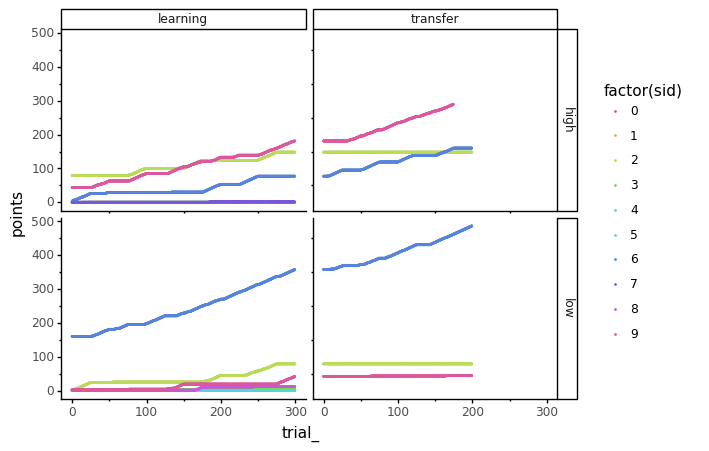

<ggplot: (188779026061)>


In [136]:
g = (gg.ggplot(all_data, gg.aes('trial_', 'points', color='factor(sid)'))
     + gg.geom_point(size=0.1)
     + gg.facet_grid('phase ~ trial_type')
    )
g.save(os.path.join(plot_dir, '0_PointsOverTrials.png'))
print(g)

## Response times

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\1_RTOverSubtrial_Details.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 117 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 117 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


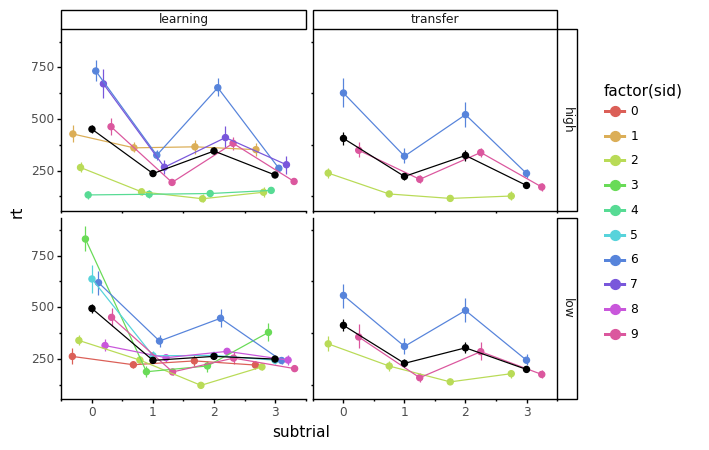

<ggplot: (-9223371848076036359)>


In [19]:
# RTs
g = (gg.ggplot(all_data, gg.aes('subtrial', 'rt', color='factor(sid)', group='sid'))
#      + gg.geom_point(position='jitter', alpha=0.3)
     + gg.stat_summary(position=gg.position_dodge(width=0.75))
     + gg.stat_summary(position=gg.position_dodge(width=0.75), geom='line')
     + gg.stat_summary(gg.aes(group=1), color='black')
     + gg.stat_summary(gg.aes(group=1), geom='line', color='black')
#      + gg.geom_violin()
#      + gg.geom_boxplot()
#      + gg.geom_hline(yintercept=5, linetype='dotted')
     + gg.facet_grid('phase ~ trial_type')
    )
g.save(os.path.join(plot_dir, '1_RTOverSubtrial_Details.png'))
print(g)

## Learning curves

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\2_LearnCurves_Trial.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 14812 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 14812 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


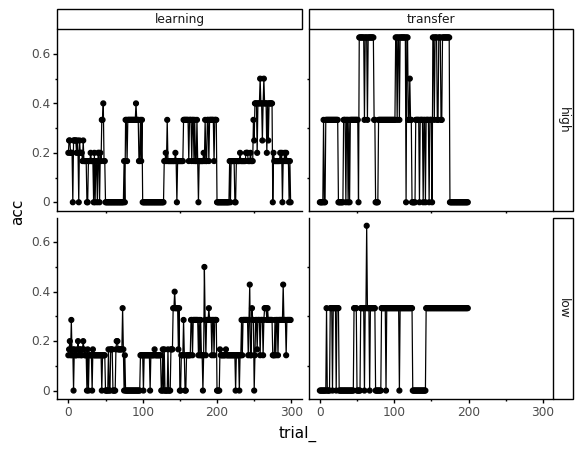

<ggplot: (188779044700)>


In [23]:
# Learning curves, averaging over goal stars 
learn_curve = (
    gg.ggplot(all_data, gg.aes('trial_', 'acc'))
    + gg.stat_summary(fun_y=np.mean, geom='point')
    + gg.stat_summary(fun_y=np.mean, geom='line')
#     + gg.stat_summary()
#     + gg.stat_summary(geom='line')
    + gg.facet_grid('phase ~ trial_type')
)
learn_curve.save(os.path.join(plot_dir, '2_LearnCurves_Trial.png'))
print(learn_curve)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\2_LearnCurves_Block.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 14812 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 14812 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


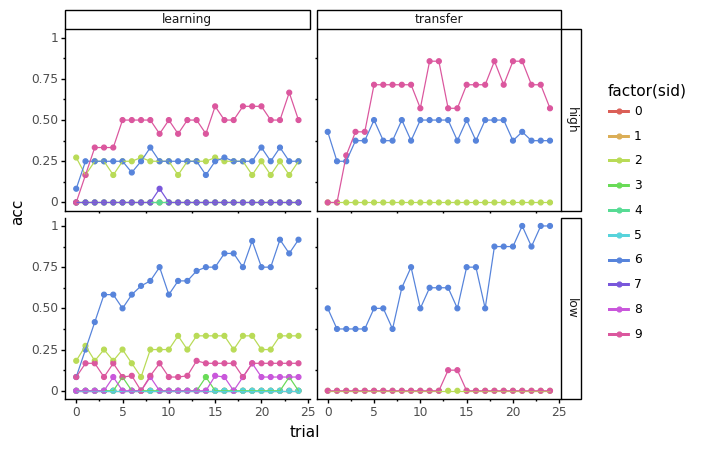

<ggplot: (-9223371848078696788)>


In [24]:
# Learning curves, trial-by-trial
l2 = learn_curve + gg.aes(x='trial', color='factor(sid)')
l2.save(os.path.join(plot_dir, '2_LearnCurves_Block.png'))
print(l2)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\2_LearnCurves_Star.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 14812 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 14812 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


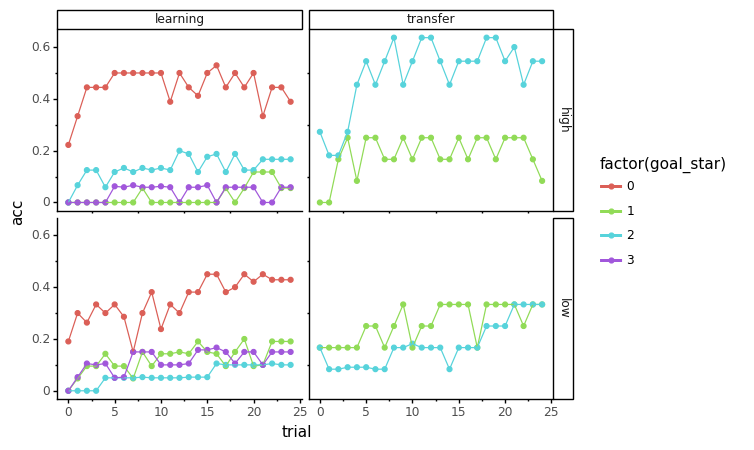

<ggplot: (188777744925)>


In [25]:
# Learning curves, by goal star
l3 = learn_curve + gg.aes(x='trial', color='factor(goal_star)')
l3.save(os.path.join(plot_dir, '2_LearnCurves_Star.png'))
print(l3)

## Performance by star

In [26]:
id_cols = ['sid', 'phase', 'trial_type', 'goal_star']
sum_dat = all_data.groupby(id_cols).mean().reset_index()[id_cols + ['acc']]
sum_dat

,sid,phase,trial_type,goal_star,acc
0,0,low,learning,0.0,0.00
1,0,low,learning,1.0,0.00
2,0,low,learning,2.0,0.00
3,0,low,learning,3.0,0.00
4,1,high,learning,0.0,0.00
...,...,...,...,...,...
59,9,low,learning,1.0,0.00
60,9,low,learning,2.0,0.00
61,9,low,learning,3.0,0.00
62,9,low,transfer,1.0,0.02


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\3_PerformanceByStar.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


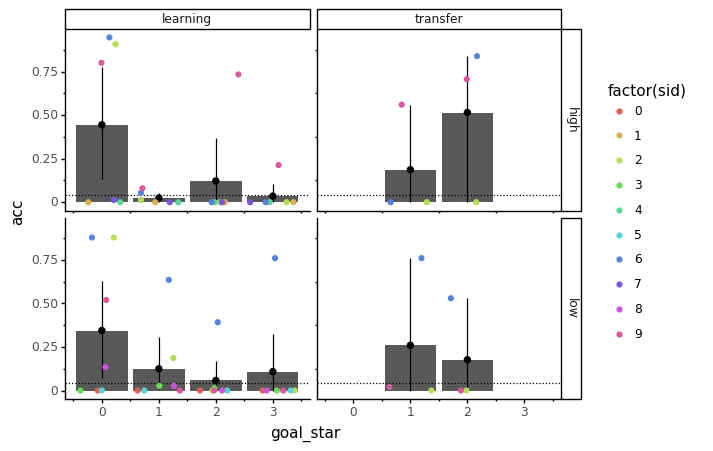

<ggplot: (188778243739)>


In [27]:
chance_perf = 1 / (4 * 3 * 2)
g = (gg.ggplot(sum_dat, gg.aes('goal_star', 'acc'))
     + gg.stat_summary(geom='bar')
     + gg.stat_summary()
     + gg.geom_hline(yintercept=chance_perf, linetype='dotted')
     + gg.geom_point(gg.aes(color='factor(sid)'), position='jitter')
     + gg.facet_grid('phase ~ trial_type')
    )
g.save(os.path.join(plot_dir, '3_PerformanceByStar.png'))
print(g)

## Collecting the wrong star

In [28]:
# Get data
id_cols = ['sid', 'phase', 'trial_type', 'unlocked_star']
sub_dat = all_data.loc[all_data.correct == 0].reset_index()
sum_dat = sub_dat.groupby(id_cols).count().reset_index()[id_cols + ['index']]
sum_dat = sum_dat.rename(columns={'index': 'n_unlocked'})
sum_dat.loc[np.isnan(sum_dat.n_unlocked), 'n_unlocked'] = 0
# sum_dat

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\4_CollectingWrongStar.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


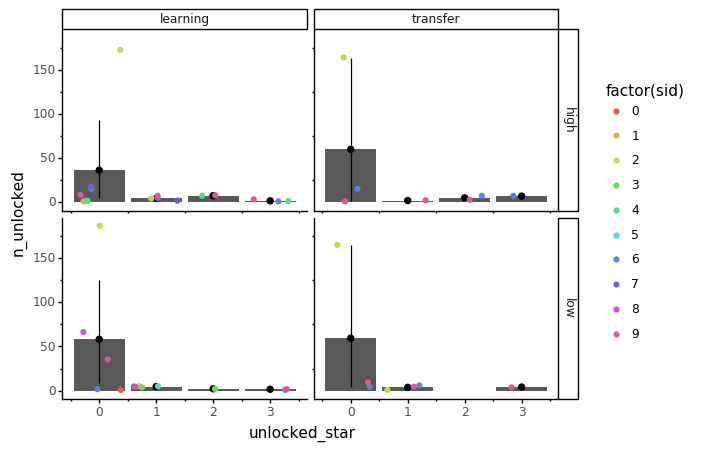

<ggplot: (-9223371848076813487)>


In [31]:
g = (gg.ggplot(sum_dat, gg.aes('unlocked_star', 'n_unlocked'))
     + gg.stat_summary(geom='bar')
     + gg.stat_summary()
     + gg.geom_point(gg.aes(color='factor(sid)'), position='jitter')
     + gg.facet_grid('phase ~ trial_type')
    )
g.save(os.path.join(plot_dir, '4_CollectingWrongStar.png'))
print(g)

## Perseverance: Following old rules after transfer

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\5_PerseveranceLowRules.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


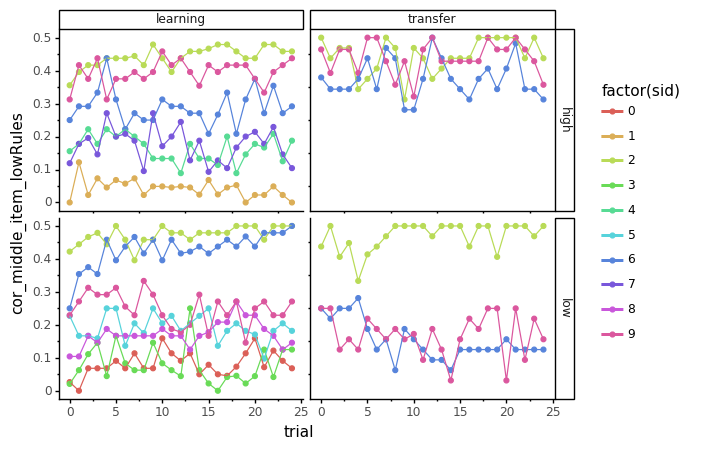

<ggplot: (188778291562)>


In [149]:
# How often do participants apply the low rules of the learning phase?
# -> Perseveration if they do it during low transfer (low rules don't work any more)!
# -> Confusion if they stop doing it during high transfer (low rules still work)!

g = (gg.ggplot(all_data, gg.aes('trial', 'cor_middle_item_lowRules', color='factor(sid)'))
     + gg.stat_summary(fun_y=np.mean, geom='point')
     + gg.stat_summary(fun_y=np.mean, geom='line')
     + gg.facet_grid('phase ~ trial_type')
    )
g.save(os.path.join(plot_dir, '5_PerseveranceLowRules.png'))
print(g)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\5_PerseveranceHighRules.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


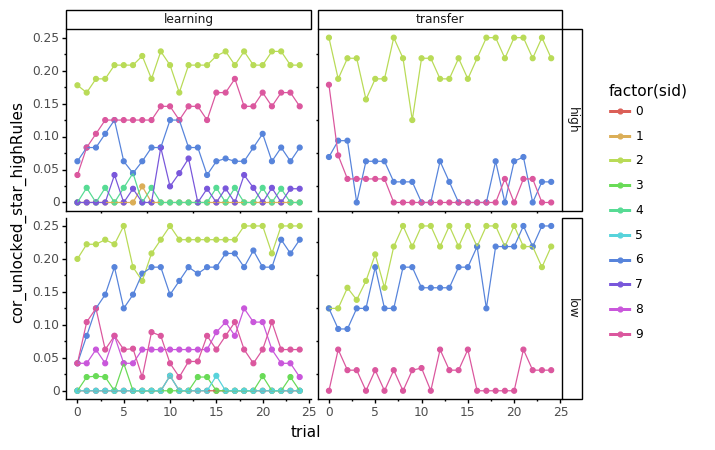

<ggplot: (188778686973)>


In [150]:
# How often do participants apply the high rules of the learning phase?
# -> Perseveration if they do it during high transfer (high rules don't work any more)!
# -> Relearning of middle-layer items if they increase during low transfer (same high rules, different low rules)!

g2 = g + gg.aes(y='cor_unlocked_star_highRules')
g2.save(os.path.join(plot_dir, '5_PerseveranceHighRules.png'))
print(g2)

## Analyzing performance by level

In [ ]:
# More details analysis of performance for low-level rules
# No decline in high transfer phase -> low rules didn't change
# Decline and relearning in low transfer phase -> low rules changed
g3 = g + gg.aes(y='cor_middle_item_lowTransferRules')
g2.save(os.path.join(plot_dir, '2_DetailsLowTransferRules.png'))
g3

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/Berkeley/CHaRLy/data/mTurk1figures\2_DetailsLowTransferRules.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [ ]:
# More details analysis of performance for high-level rules
# Decline and relearning in high transfer phase -> high rules changed
# Decline and relearning in low transfer phase -> high rules are the same, but low-level components changed
g3 = g + gg.aes(y='cor_unlocked_star_highTransferRules')
g2.save(os.path.join(plot_dir, '2_DetailsHighTransferRules.png'))
g3